# Movies dataset

This project aims to recommend movies to users based on other users' ratings and tag similarity 

## About the dataset
This dataset (ml-25m) describes 5-star rating from MovieLens. It contains 25000095 ratings and 1093360 tag applications across 62423 movies. These data were created by 162541 users between January 09, 1995 and November 21, 2019. This dataset was generated on November 21, 2019.

it contains 4 files, which are :
- movies 
- ratings
- genome-tags
- genome-scores

---
#### Step 1 : set up 

In [ ]:
%%capture

# data management
! pip install -U pandas
! pip install -U numpy

# data visualization
! pip install -U matplotlib
! pip install -U plotnine

# modeling
! pip install -U scikit-learn



In [ ]:
! pip uninstall matplotlib
! pip install matplotlib==3.1.3

In [ ]:
! pip install mxnet
#! pip install graphviz
! pip install -U d2l
! pip install implicit
! pip install recmetrics
! pip install ml_metrics

import libraries

In [86]:
import os
from mxnet import gluon, np
import pandas as pd
from d2l import mxnet as d2l
import sys
import numpy as np
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
import random
import implicit 
from sklearn.model_selection import train_test_split, KFold, RepeatedKFold, cross_val_score
import recmetrics
from pandas.core.dtypes.inference import is_dict_like
import matplotlib.pyplot as plt
import ml_metrics as metrics
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from skopt import gp_minimize


import data from google drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


---
#### Step 2 : upload files

movies file contain info about 62423 movies,
- movieId : unique identifer across files
- title : movie title
- genres : pipe-separated list of movie genres

In [5]:
movies=pd.read_csv('/content/drive/MyDrive/data/movies.csv')

In [6]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


ratings file contain info about 25000095 ratings,
- movieId : movie unique identifer across files
- userId : user unique identifer across files
- rating : user rating out of 5 stars

In [7]:
ratings =pd.read_csv('/content/drive/MyDrive/data/ratings.csv')

In [8]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [9]:
ratings.drop('timestamp',axis = 1 , inplace = True)

tags are distrbuted in 2 files:
- genome-tags : which includes the tags id and the tag name
- genome-scores : which includes the tage id, the movie id and the relevance between them (at scale from 0 to 1)


In [10]:
scores =pd.read_csv('/content/drive/MyDrive/data/genome-scores.csv')

In [11]:
scores.head()

,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250
3,1,4,0.07575
4,1,5,0.14075


In [12]:
tags =pd.read_csv('/content/drive/MyDrive/data/genome-tags.csv')

In [13]:
tags.sample(10)

,tagId,tag
1101,1102,wedding
792,793,poker
409,410,freedom
330,331,drugs
415,416,funniest movies
240,241,complex characters
837,838,rape
994,995,surreal
771,772,penguins
10,11,3d


---
#### Step 3 : exploring

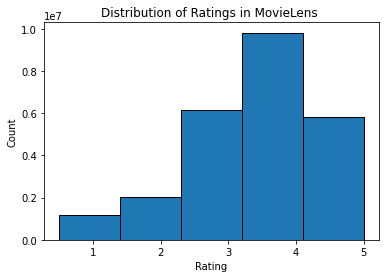

In [118]:
d2l.plt.hist(ratings['rating'], bins=5, ec='black')
d2l.plt.xlabel('Rating')
d2l.plt.ylabel('Count')
d2l.plt.title('Distribution of Ratings in MovieLens ')
d2l.plt.show()

some movies have a lot of ratings and some have only 1, 75% of them have 36 ratings or less

In [15]:
counts = ratings['movieId'].value_counts()
counts.describe()

count    59047.000000
mean       423.393144
std       2477.885821
min          1.000000
25%          2.000000
50%          6.000000
75%         36.000000
max      81491.000000
Name: movieId, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


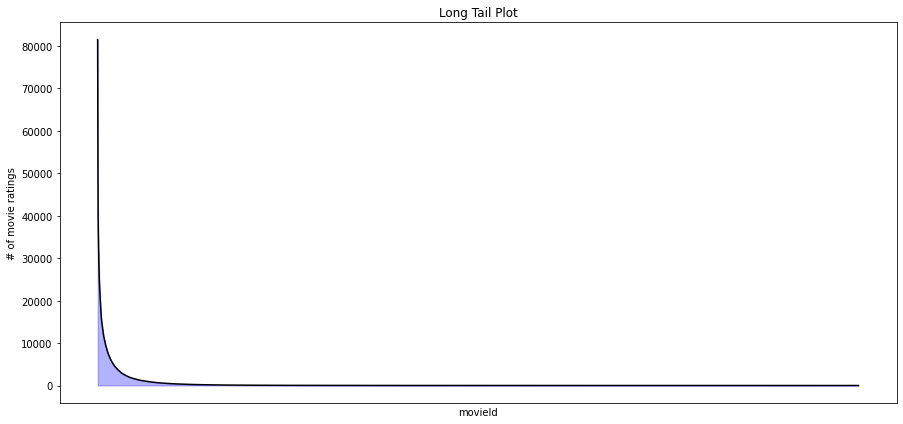

In [119]:
fig = plt.figure(figsize=(15, 7))
recmetrics.long_tail_plot(df=ratings, 
             item_id_column="movieId", 
             interaction_type="movie ratings", 
             x_labels=False)

---
#### Step 4 : model building

the project requirments :
- the system can show search suggestion if there's more than one movie with the same name
- the system will show the user the suggested movies based on the one they like, the recommendation will be based on other users preferances and the tag relevance between the movie and other movies
 
it is hybird recommendation system that uses collaborative-based and content-based algorithms 



In [17]:
#input movie
movieName= 'Toy Story'
movieRow = movies[movies['title'].str.contains(movieName)]
movieRow

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3021,3114,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy
14813,78499,Toy Story 3 (2010),Adventure|Animation|Children|Comedy|Fantasy|IMAX
20497,106022,Toy Story of Terror (2013),Animation|Children|Comedy
22633,115875,Toy Story Toons: Hawaiian Vacation (2011),Adventure|Animation|Children|Comedy|Fantasy
22634,115879,Toy Story Toons: Small Fry (2011),Adventure|Animation|Children|Comedy|Fantasy
24062,120468,Toy Story Toons: Partysaurus Rex (2012),Animation|Children|Comedy
24064,120474,Toy Story That Time Forgot (2014),Animation|Children
59767,201588,Toy Story 4 (2019),Adventure|Animation|Children|Comedy


In [18]:
movieID = 1

In [19]:
#look for the highest related tag
AllMovieScores = scores[scores['movieId']==movieID]
AllMovieScores.sort_values(by=['relevance'],ascending=False, inplace=True)
AllMovieScores.head()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,movieId,tagId,relevance
1035,1,1036,0.99925
243,1,244,0.99875
785,1,786,0.99575
588,1,589,0.98575
63,1,64,0.98425


In [20]:
# who also likes the movie ?
UsersWhoWatched = ratings[ratings['movieId']==movieID]
UsersWhoWatched

,userId,movieId,rating
70,2,1,3.5
254,3,1,4.0
910,4,1,3.0
1152,5,1,4.0
1304,8,1,4.0
...,...,...,...
24997918,162529,1,2.0
24998300,162530,1,5.0
24998525,162533,1,4.5
24998892,162534,1,4.0


# Model- based collabrative filtering
# ALS - Alternating Least Square 

splitting the data

In [52]:
y = ratings["userId"]
train_strat, test_strat = train_test_split(ratings, train_size=0.60, random_state=123)

convert into matrises as ALS model input

In [54]:
#smaller train matrices 
sparse_movie_user = sparse.csr_matrix((train_strat['rating'].astype(float), (train_strat['movieId'], train_strat['userId'])))
sparse_user_movie = sparse.csr_matrix((train_strat['rating'].astype(float), (train_strat['userId'], train_strat['movieId'])))

In [24]:
#os.environ['MKL_NUM_THREADS'] = '1'

In [55]:
#Building the model
model = implicit.gpu.als.AlternatingLeastSquares(regularization=0.03, iterations=40)
alpha_val = 2
data_conf = (sparse_user_movie * alpha_val).astype('double')
model.fit(data_conf)

  0%|          | 0/20 [00:00<?, ?it/s]

In [96]:
#Get Recommendations
# returns 2 variables: ids, scores
user_id =[1,100,200,500]
def ALSrecommendations(user_id):
  return model.recommend(user_id, sparse_user_movie[user_id],N=10)


function to retrive the movies names from list of ids :

In [57]:
def findMoviesName(idList):
    listofmovies = pd.DataFrame()
    idList = idList.tolist()
    for id in idList:
        listofmovies = listofmovies.append(movies[movies['movieId']==id], ignore_index = False)

    return listofmovies

fuction to join movies and ratings dataframes :

In [58]:
def joinRatingswithMovies(ratingList):
    return pd.merge(ratingList,movies,on='movieId')


function to get the movies that atr in ratings

In [59]:
def ratingsToMovies(ratingsList):
    movieslist = pd.DataFrame()
    for index, row in ratingsList.iterrows():
        movieslist = movieslist.append(movies[movies['movieId'] == row['movieId']], ignore_index = True)
    return movieslist



# Memory-based content filtering

function used to minimize the tags and remove redundent :

In [60]:

def deleteTags(ListoftagsIds,scores):
    TagOnly = scores
    #find each movie
    for id in ListoftagsIds:
        TagOnly=TagOnly[TagOnly['tagId']!=id]
    return TagOnly

deleting tags for the memory- based model

In [61]:
# 9,1980s + 13,80s 
#15,aardman + 16,aardman studios
#22,adapted from:book + 107,based on a book + 113,based on book + 152,book + 153,book was better
#23,adapted from:comic + 108,based on a comic + 114,based on comic + 231,comic + 232,comic book + 233,comic book adaption + 234,comics + 290,dc comics
TagOnly = deleteTags([13,16,107,113,152,153,108,114,231,232,233,234,290],scores)
#24,adapted from:game + 112,based on a video game + 245,computer game + 1074,video game + 1075,video game adaptation + 1076,video games + 1077,videogame
#43,alien + 44,alien invasion + 45,aliens
#59,android(s)/cyborg(s) + 60,androids
#886,sci fi + 887,sci-fi + 888,science + 889,science fiction + 890,scifi + 891,scifi cult
TagOnly = deleteTags([112,245,1074,1075,1076,1077,44,45,60,887,888,889,890,891],TagOnly)

#61,animal movie + 62,animals + 316,dog + 317,dogs + 318,dolphins + 783,pigs

#63,animated + 64,animation + 65,anime + 244,computer animation + 310,disney animated feature

#75,art + 78,artist + 79,artistic

#81,assassin + 82,assassination + 83,assassins

#87,australia + 88,australian

#115,based on true story + 110,based on a true story + 1047,true story

#1013,teen + 1014,teen movie + 1015,teenager + 1016,teenagers + 1017,teens

#127,best war films + 1096,war + 1097,war movie + 1098,wartime

#133,biographical + 134,biography

#141,black comedy + 286,dark comedy + 289,dark humor

#145,blood + 146,bloody

#798,political + 799,political corruption + 800,politics + 1119,world politics

#155,boring + 156,boring!

#176,camp + 177,campy

#208,christian + 209,christianity

#220,clever + 992,suprisingly clever + 550,intellectual + 551,intelligent + 552,intelligent sci-fi + 430,genius

#221,clones + 222,cloning

#235,coming of age + 236,coming-of-age

#240,complex + 242,complicated

#261,court + 262,courtroom + 263,courtroom drama

#278,cute + 279,cute!

# 283,dance + 284,dancing

#296,depressing + 297,depression

#323,drama + 324,dramatic + 376,family drama

#357,environment + 358,environmental

#371,fairy tale + 372,fairy tales

#384,father son relationship + 385,father-son relationship

#377,fantasy + 378,fantasy world

#387,feel good movie + 388,feel-good

#435,ghosts + 436,ghosts/afterlife + 35,afterlife
#389,fight scenes + 390,fighting

#684,music + 685,music business + 686,musical + 687,musicians

#329,drug abuse + 330,drug addiction + 331,drugs + 499,heroin + 500,heroine + 501,heroine in tight suit

#548,inspirational + 549,inspiring

#696,nazi + 697,nazis + 698,neil gaiman + 699,neo-nazis

#905,sex + 907,sexual + 909,sexuality + 911,sexy

#908,sexual abuse + 910,sexualized violence

#789,plot twist + 1049,twist + 1050,twist ending + 1051,twists & turns

#987,super hero + 988,super-hero + 989,superhero + 990,superheroes + 991,supernatural

#725,nudity + 726,nudity (full frontal - brief) + 727,nudity (full frontal - notable) + 728,nudity (full frontal) + 729,nudity (rear) + 730,nudity (topless - brief) + 731,nudity (topless - notable) + 732,nudity (topless)

#414,fun + 415,fun movie + 416,funniest movies + 417,funny + 418,funny as hell + 1071,very funny + 1058,unintentionally funny + 933,so bad it's funny + 920,silly fun + 333,dumb but funny


merge tags, scores and movies in one dataFrame

In [63]:
MovieTagsUnion = scores.merge(tags, on = 'tagId').merge(movies, on = 'movieId')

 rank based on tags

In [ ]:
MovieTagsUnion['relevance_rank'] = MovieTagsUnion.groupby("movieId")["relevance"].rank(method = "first", ascending = False).astype('int64')

get a list of top 100 tags for each movie

In [64]:
mv_tags_list = MovieTagsUnion[MovieTagsUnion.relevance_rank <= 100].groupby(['movieId','title'])['tag'].apply(lambda x: ','.join(x)).reset_index()
mv_tags_list['tag_list'] = mv_tags_list.tag.map(lambda x: x.split(','))

function to find movies similar to one movie

In [65]:
def findsimilarMovie(target_movie):
  # compute Jaccard Index to get most similar movies to target movie
  target_movieName=  mv_tags_list[mv_tags_list['movieId'] == target_movie]
  similarList = pd.DataFrame()
  if (len(target_movieName) != 0 ):
    target_movieName = target_movieName['title'].values[0]
    pd.reset_option('display.max_colwidth')
    target_tag_list = mv_tags_list[mv_tags_list['movieId'] == target_movie].tag_list.values[0]
    mv_tags_list_sim = mv_tags_list[['movieId','title','tag_list','tag']]
    mv_tags_list_sim['jaccard_sim'] = mv_tags_list_sim.tag_list.map(lambda x: len(set(x).intersection(set(target_tag_list))) / len(set(x).union(set(target_tag_list))))
    print(f'Movies most similar to {target_movieName} based on tags:')
    text = ','.join(mv_tags_list_sim.sort_values(by = 'jaccard_sim', ascending = False).head(25)['tag'].values)
    similarList = mv_tags_list_sim.sort_values(by = 'jaccard_sim', ascending = False).iloc[1:11]

  return similarList

find similar movies based on user likes 

In [66]:
def findJaccardRecommendations(SingleuserId):
  original =train_strat[train_strat['userId']==SingleuserId]['movieId'].tolist()
  results =pd.DataFrame()
  for movie in original:
    results = pd.concat([results,findsimilarMovie(movie)], ignore_index=True)
  results.sort_values(by = 'jaccard_sim', ascending = False, inplace = True , ignore_index=True)
  return results.iloc[0:10]

## Merging the models

In [ ]:
def HybridRecommenderSystem(userID):
  jaccResults = findJaccardRecommendations(userID)['movieId'].tolist()
  ids, ALS_scores = ALSrecommendations([userID])
  # weighted selection
  print(jaccResults)
  Results = []
  for i in range(0,5):
    Results.append(jaccResults[i])
    Results.append(ids[0][i])
  return Results

# Testing 

for the evaluation, a baseline is considered, the baseline is a basic standard for what we expect from the recommender system

The model is trying to be better compared to the baseline, there are 2 baselines:
- random recommender : recommend based on random selection
- popular recommender : recommend based on the most popular movies without personlization


random recommender

In [67]:
baseline = []
for i in range(1,5):
    baseline.append(movies.sample(10)['movieId'].tolist())

[[4847, 4485, 147, 27871, 161181, 70372, 200580, 178619, 153210, 113943],
 [95533, 100390, 201552, 179153, 198963, 174511, 164079, 156960, 7647, 163128],
 [144025, 178167, 85284, 134859, 3545, 180073, 133485, 179635, 192393, 40898],
 [79686, 181099, 3403, 139819, 1280, 203250, 2930, 203669, 122439, 164001]]

popular recommender

In [68]:
popular = ratings.movieId.value_counts().head(10).index.tolist()
popular = [popular,popular,popular,popular]

what the users actully like based on the test set

In [81]:
RealUserLikes = []
for id in user_id :
    RealUserLikes.append(ratingsToMovies(test_strat[test_strat['userId']==id])['movieId'].tolist())
  

ALS model recommender

In [114]:
ALSmodel_ids,scores = ALSrecommendations(user_id)

Jaccard recommender

In [ ]:
JaccardListForAllUsers = []
for id in user_id :
    JaccardListForAllUsers.append(findJaccardRecommendations(id)['movieId'].tolist())

hybird recommender

In [ ]:
hybridModel = []
for id in user_id :
    hybridModel.append(HybridRecommenderSystem(id))

## evalution matrises

Mean average precision at k

In [73]:
metrics.mapk(RealUserLikes,baseline)

0.0

In [74]:
metrics.mapk(RealUserLikes,popular)

0.027499999999999997

In [82]:
metrics.mapk(RealUserLikes,ALSrecommendations)

0.20493055555555556

In [75]:
metrics.mapk(RealUserLikes,JaccardListForAllUsers)

0.0225

In [110]:
metrics.mapk(RealUserLikes,hybridModel)

0.08055555555555555

Mean average recall at k

In [76]:
random_mark = []
for K in np.arange(1, 11):
    random_mark.extend([recmetrics.mark(RealUserLikes,baseline, k=K)])
random_mark

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [120]:
pop_mark = []
for K in np.arange(1, 11):
    pop_mark.extend([recmetrics.mark(RealUserLikes, popular, k=K)])
pop_mark

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.022435897435897436,
 0.022435897435897436,
 0.022435897435897436,
 0.022435897435897436,
 0.024935897435897435]

In [115]:
model_mark = []
for K in np.arange(1, 11):
    model_mark.extend([recmetrics.mark(RealUserLikes, ALSmodel_ids, k=K)])
model_mark

[0.009615384615384616,
 0.019230769230769232,
 0.03193257359924027,
 0.04154795821462488,
 0.0511633428300095,
 0.060778727445394115,
 0.060778727445394115,
 0.06919218898385565,
 0.0777391975308642,
 0.0802391975308642]

In [79]:
Jac_mark = []
for K in np.arange(1, 11):
    Jac_mark.extend([recmetrics.mark(RealUserLikes, JaccardListForAllUsers, k=K)])
Jac_mark

[0.0,
 0.0125,
 0.0125,
 0.0125,
 0.014351851851851852,
 0.014351851851851852,
 0.014351851851851852,
 0.014351851851851852,
 0.014351851851851852,
 0.016203703703703706]